# Sentimental using weighted scores

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
path = './sp500_news_and_sentimental_weights.csv'
df = pd.read_csv(path)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [13]:
df.head()

,ticker,date,title,source,link_source,positivity_text,neutrality_text,negativity_text,compound_text,stock,gisc_sectors,year,month,weight
0,zts,2013-05-22 14:52:27,Pfizer to spin off Zoetis stake to shareholders,Reuters,http://feeds.reuters.com/~r/reuters/businessNe...,0.000,1.000,0.0,0.000,Zoetis,Health Care,2013,5,0.0
1,zts,2013-06-24 16:28:40,Pfizer says shareholders snap up remaining Zoe...,Reuters,http://feeds.reuters.com/~r/reuters/businessNe...,0.239,0.761,0.0,0.296,Zoetis,Health Care,2013,6,0.0
2,zts,2015-06-25 22:35:18,Valeant offers to buy Zoetis: WSJ,Reuters,http://feeds.reuters.com/~r/reuters/businessNe...,0.000,1.000,0.0,0.000,Zoetis,Health Care,2015,6,0.0
3,zts,2016-05-10 00:57:59,Ackman's Pershing Square seeks to sell Zoetis ...,Reuters,http://feeds.reuters.com/~r/reuters/businessNe...,0.167,0.833,0.0,0.296,Zoetis,Health Care,2016,5,0.0
4,zts,2017-02-27 13:10:00,Technical Reports on Generic Drugs Stocks -- Z...,PR Newswire,https://markets.businessinsider.com/news/stock...,0.000,1.000,0.0,0.000,Zoetis,Health Care,2017,2,0.0


# Compute mean daily sentimental analysis of each stock

In [14]:
# add day column to the dataframe to compute daily mean
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day

In [15]:
# computation daily means for each stock
mean_stock_sentiment_daily = df.groupby(['ticker', 'year', 'month', 'day']).agg({
    'positivity_text': 'mean',
    'neutrality_text': 'mean',
    'negativity_text': 'mean',
    'compound_text': 'mean'
}).reset_index()

In [16]:
# check
mean_stock_sentiment_daily[mean_stock_sentiment_daily['ticker'] == 'aapl'].head(3)

,ticker,year,month,day,positivity_text,neutrality_text,negativity_text,compound_text
1479,aapl,2011,5,19,0.0,1.0,0.0,0.0
1480,aapl,2011,5,21,0.0,1.0,0.0,0.0
1481,aapl,2011,6,5,0.0,1.0,0.0,0.0


In [17]:
# create date column and drop other columns
mean_stock_sentiment_daily['date'] = pd.to_datetime(mean_stock_sentiment_daily[['year', 'month', 'day']])
# mean_stock_sentiment_daily.drop(columns=['year', 'month', 'day'], axis=1, inplace=True)

In [18]:
# check
mean_stock_sentiment_daily.head(-5)

,ticker,year,month,day,positivity_text,neutrality_text,negativity_text,compound_text,date
0,a,2007,10,9,0.1110,0.8890,0.000,0.25000,2007-10-09
1,a,2016,9,29,0.2620,0.7380,0.000,0.49390,2016-09-29
2,a,2016,11,15,0.0000,1.0000,0.000,0.00000,2016-11-15
3,a,2016,11,18,0.1800,0.8200,0.000,0.29600,2016-11-18
4,a,2017,2,2,0.0000,1.0000,0.000,0.00000,2017-02-02
...,...,...,...,...,...,...,...,...,...
260931,zts,2024,4,16,0.1325,0.8675,0.000,0.10115,2024-04-16
260932,zts,2024,4,18,0.1080,0.8920,0.000,0.14800,2024-04-18
260933,zts,2024,4,23,0.0000,1.0000,0.000,0.00000,2024-04-23
260934,zts,2024,4,28,0.0000,0.8040,0.196,-0.29600,2024-04-28


Add weight column from another CSV

In [19]:
# top50 stocks of SP500 with computed weights
df_top50 = pd.read_csv('./weights_sp500.csv')
df_top50.rename(columns={'Unnamed: 0' : 'stock'}, inplace=True)
df_top50['stock'] = df_top50['stock'].str.lower()
df_top50.rename(columns={'stock':'ticker'}, inplace = True)
df_top50.head()

,ticker,weight
0,aapl,0.100563
1,msft,0.085854
2,amzn,0.067343
3,brk,0.039403
4,goog,0.035115


In [20]:
# Perform left merge to assign weights
mean_stock_sentiment_daily = pd.merge(mean_stock_sentiment_daily, df_top50, on='ticker', how='left')

# Fill NaN weights with 0 --> stocks which are not in top50 will have weight=0
mean_stock_sentiment_daily['weight'].fillna(0, inplace=True)
mean_stock_sentiment_daily.head()

,ticker,year,month,day,positivity_text,neutrality_text,negativity_text,compound_text,date,weight
0,a,2007,10,9,0.111,0.889,0.0,0.2500,2007-10-09,0.0
1,a,2016,9,29,0.262,0.738,0.0,0.4939,2016-09-29,0.0
2,a,2016,11,15,0.000,1.000,0.0,0.0000,2016-11-15,0.0
3,a,2016,11,18,0.180,0.820,0.0,0.2960,2016-11-18,0.0
4,a,2017,2,2,0.000,1.000,0.0,0.0000,2017-02-02,0.0


In [21]:
# compute weighted sentiment scores
mean_stock_sentiment_daily['positivity_weighted'] = mean_stock_sentiment_daily['weight'] * mean_stock_sentiment_daily['positivity_text']
mean_stock_sentiment_daily['neutrality_weighted'] = mean_stock_sentiment_daily['weight'] * mean_stock_sentiment_daily['neutrality_text']
mean_stock_sentiment_daily['negativity_weighted'] = mean_stock_sentiment_daily['weight'] * mean_stock_sentiment_daily['negativity_text']
mean_stock_sentiment_daily['compound_weighted'] = mean_stock_sentiment_daily['weight'] * mean_stock_sentiment_daily['compound_text']

In [22]:
# check
mean_stock_sentiment_daily[mean_stock_sentiment_daily['ticker'] == 'aapl']

,ticker,year,month,day,positivity_text,neutrality_text,negativity_text,compound_text,date,weight,positivity_weighted,neutrality_weighted,negativity_weighted,compound_weighted
1479,aapl,2011,5,19,0.000000,1.000000,0.000000,0.000000,2011-05-19,0.100563,0.000000,0.100563,0.000000,0.000000
1480,aapl,2011,5,21,0.000000,1.000000,0.000000,0.000000,2011-05-21,0.100563,0.000000,0.100563,0.000000,0.000000
1481,aapl,2011,6,5,0.000000,1.000000,0.000000,0.000000,2011-06-05,0.100563,0.000000,0.100563,0.000000,0.000000
1482,aapl,2011,6,6,0.135000,0.450000,0.414000,-0.476700,2011-06-06,0.100563,0.013576,0.045254,0.041633,-0.047939
1483,aapl,2011,6,11,0.000000,1.000000,0.000000,0.000000,2011-06-11,0.100563,0.000000,0.100563,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550,aapl,2024,5,7,0.084167,0.847667,0.068111,0.016939,2024-05-07,0.100563,0.008464,0.085244,0.006849,0.001703
4551,aapl,2024,5,8,0.162000,0.801312,0.036687,0.244125,2024-05-08,0.100563,0.016291,0.080583,0.003689,0.024550
4552,aapl,2024,5,9,0.194200,0.805800,0.000000,0.335140,2024-05-09,0.100563,0.019529,0.081034,0.000000,0.033703
4553,aapl,2024,5,10,0.145917,0.808250,0.045833,0.211192,2024-05-10,0.100563,0.014674,0.081280,0.004609,0.021238


In [23]:
# compute daily sum of the weighted scores
final = mean_stock_sentiment_daily.groupby(['date']).agg({
                                    'positivity_weighted': 'sum',
                                    'neutrality_weighted': 'sum',
                                    'negativity_weighted': 'sum',
                                    'compound_weighted': 'sum'
}).reset_index()

In [24]:
final.tail(10)

,date,positivity_weighted,neutrality_weighted,negativity_weighted,compound_weighted
4791,2024-05-05,0.036900,0.389792,0.016131,0.033593
4792,2024-05-06,0.100099,0.765758,0.057249,0.084064
4793,2024-05-07,0.100464,0.718716,0.030607,0.114414
4794,2024-05-08,0.150363,0.665496,0.031224,0.206106
4795,2024-05-09,0.101305,0.658765,0.034765,0.107202
4796,2024-05-10,0.091895,0.711477,0.039176,0.094914
4797,2024-05-11,0.124024,0.383307,0.007845,0.193947
4798,2024-05-14,0.003137,0.028346,0.007920,-0.007291
4799,2024-05-15,0.002010,0.037394,0.000000,0.002657
4800,2024-05-16,0.002512,0.036891,0.000000,0.003349


In [25]:
# describe numerical values
summary_statistics = final.describe(include=[np.number])
summary_statistics

,positivity_weighted,neutrality_weighted,negativity_weighted,compound_weighted
count,4801.000000,4801.000000,4801.000000,4801.000000
mean,0.039833,0.306379,0.018580,0.034343
std,0.039803,0.255823,0.018098,0.056386
min,0.000000,0.000000,0.000000,-0.153588
25%,0.003323,0.067025,0.000000,0.000000
50%,0.027899,0.237355,0.015579,0.014489
75%,0.067777,0.570468,0.030769,0.065167
max,0.222334,0.861241,0.095579,0.327769


In [26]:
# LaTeX table of above table
print(summary_statistics.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & positivity_weighted & neutrality_weighted & negativity_weighted & compound_weighted \\
\midrule
count & 4801.000000 & 4801.000000 & 4801.000000 & 4801.000000 \\
mean & 0.039833 & 0.306379 & 0.018580 & 0.034343 \\
std & 0.039803 & 0.255823 & 0.018098 & 0.056386 \\
min & 0.000000 & 0.000000 & 0.000000 & -0.153588 \\
25% & 0.003323 & 0.067025 & 0.000000 & 0.000000 \\
50% & 0.027899 & 0.237355 & 0.015579 & 0.014489 \\
75% & 0.067777 & 0.570468 & 0.030769 & 0.065167 \\
max & 0.222334 & 0.861241 & 0.095579 & 0.327769 \\
\bottomrule
\end{tabular}



# Plot of the Daily Sentiment Values starting from 2016

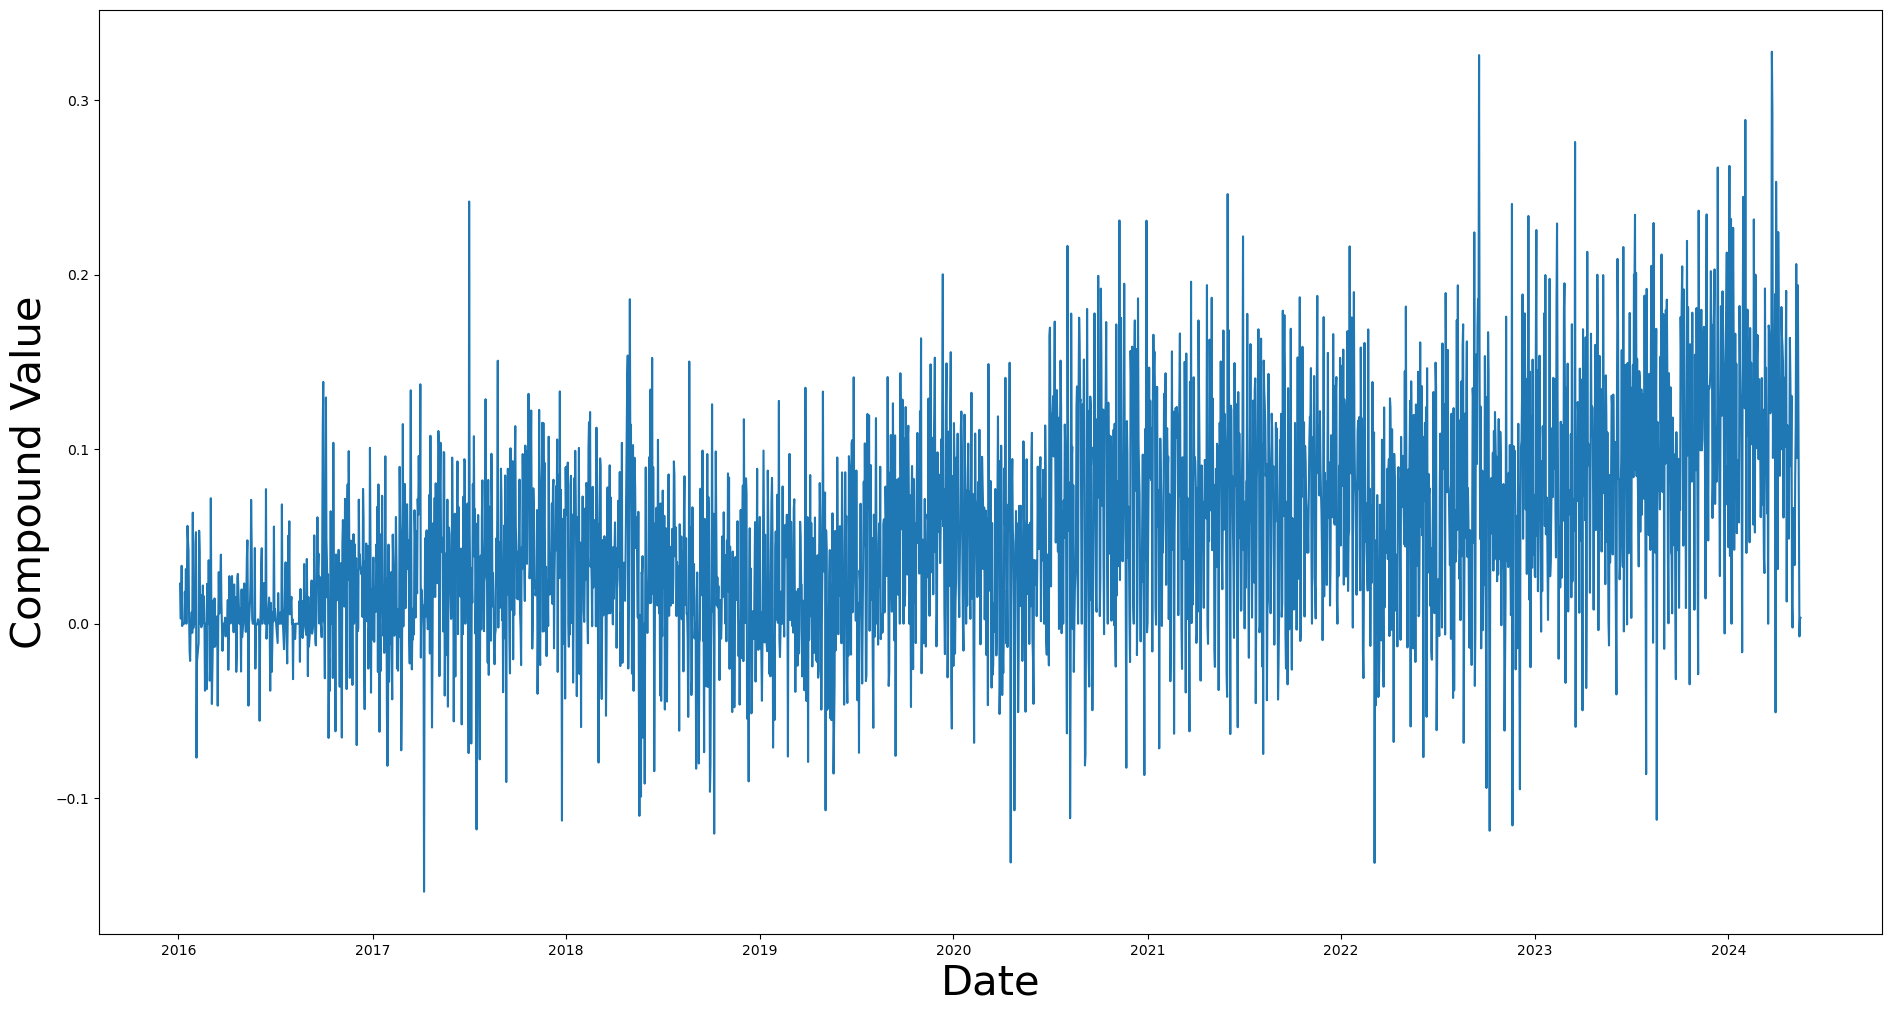

In [27]:
final_modified = final[final['date'].dt.year >= 2016 ]

# title and labels
plt.figure(figsize=(23, 12))
# plt.title('Daily Compound Value', fontsize = 30)
plt.xlabel('Date', fontsize = 30)
plt.ylabel('Compound Value', fontsize = 30)

plt.plot(final_modified['date'] ,final_modified['compound_weighted']) 
# final_modified

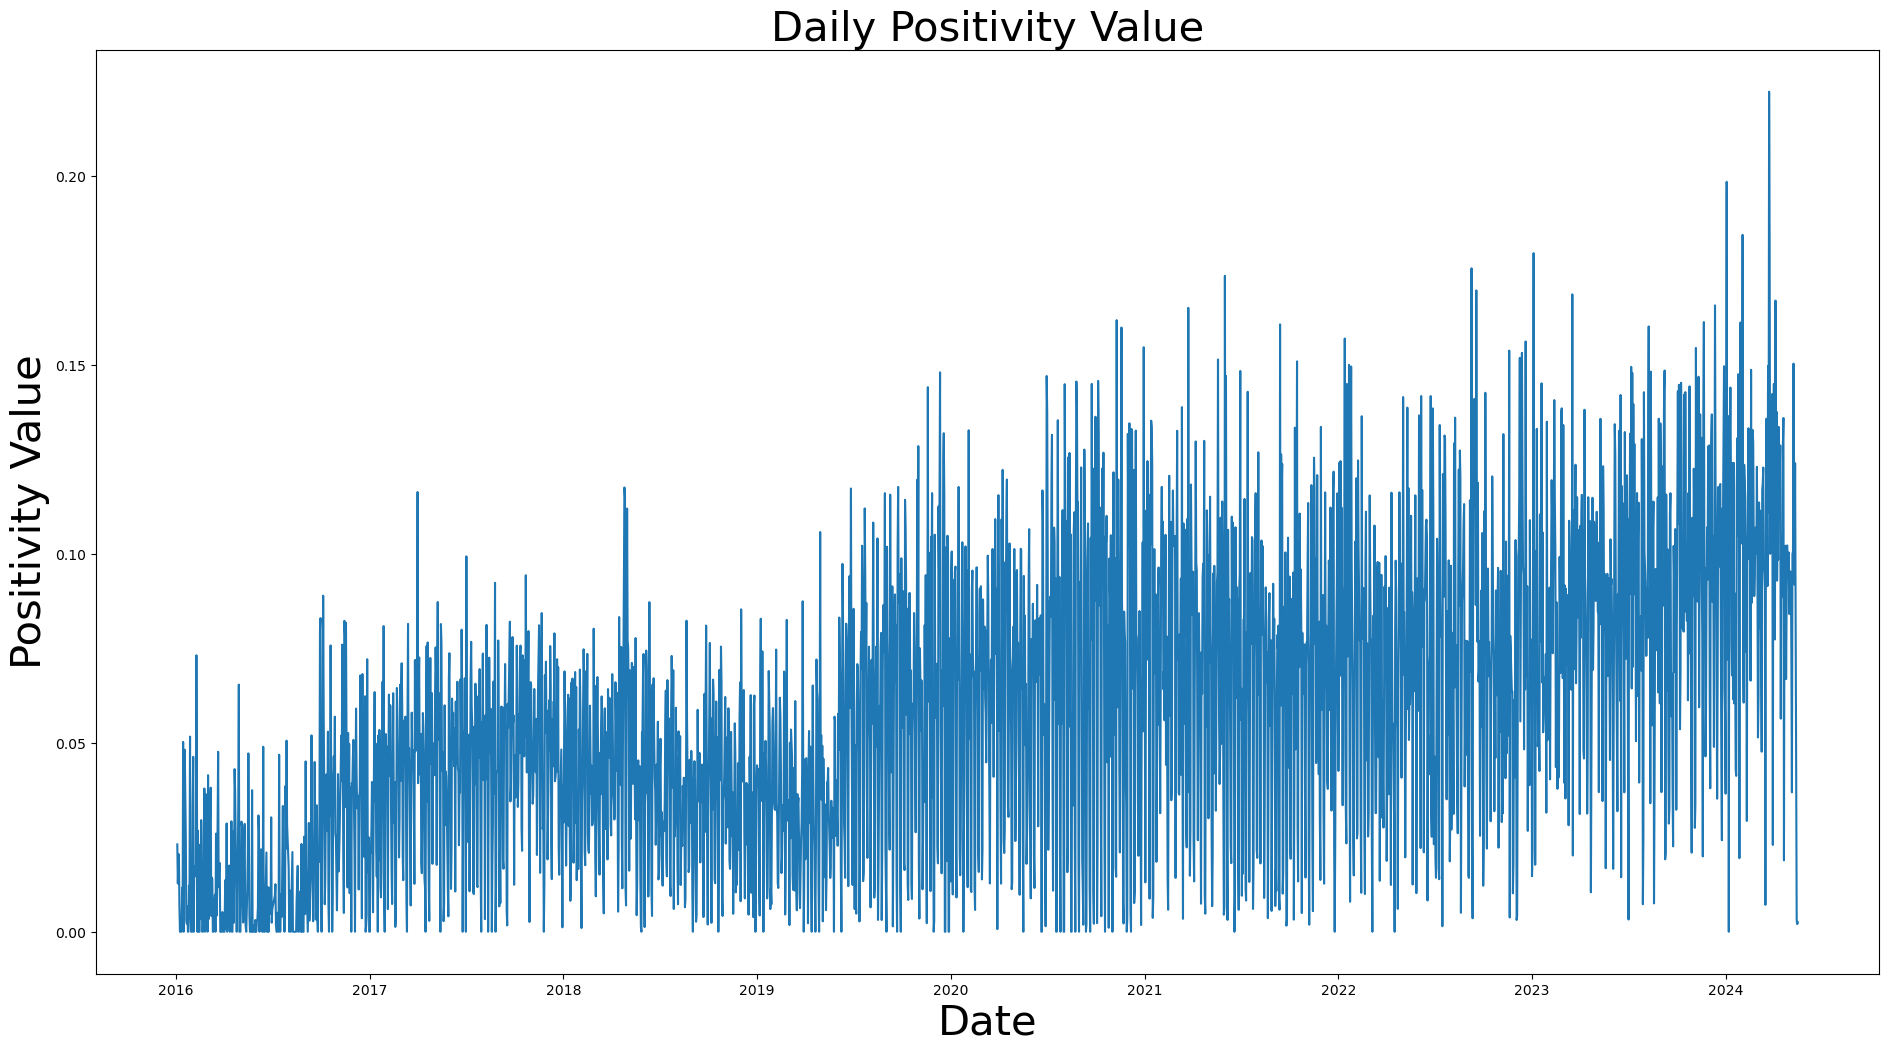

In [28]:
# Plot of the positivity

plt.figure(figsize=(23, 12))
plt.title('Daily Positivity Value', fontsize = 30)
plt.xlabel('Date', fontsize = 30)
plt.ylabel('Positivity Value', fontsize = 30)

plt.plot(final_modified['date'] ,final_modified['positivity_weighted']) 

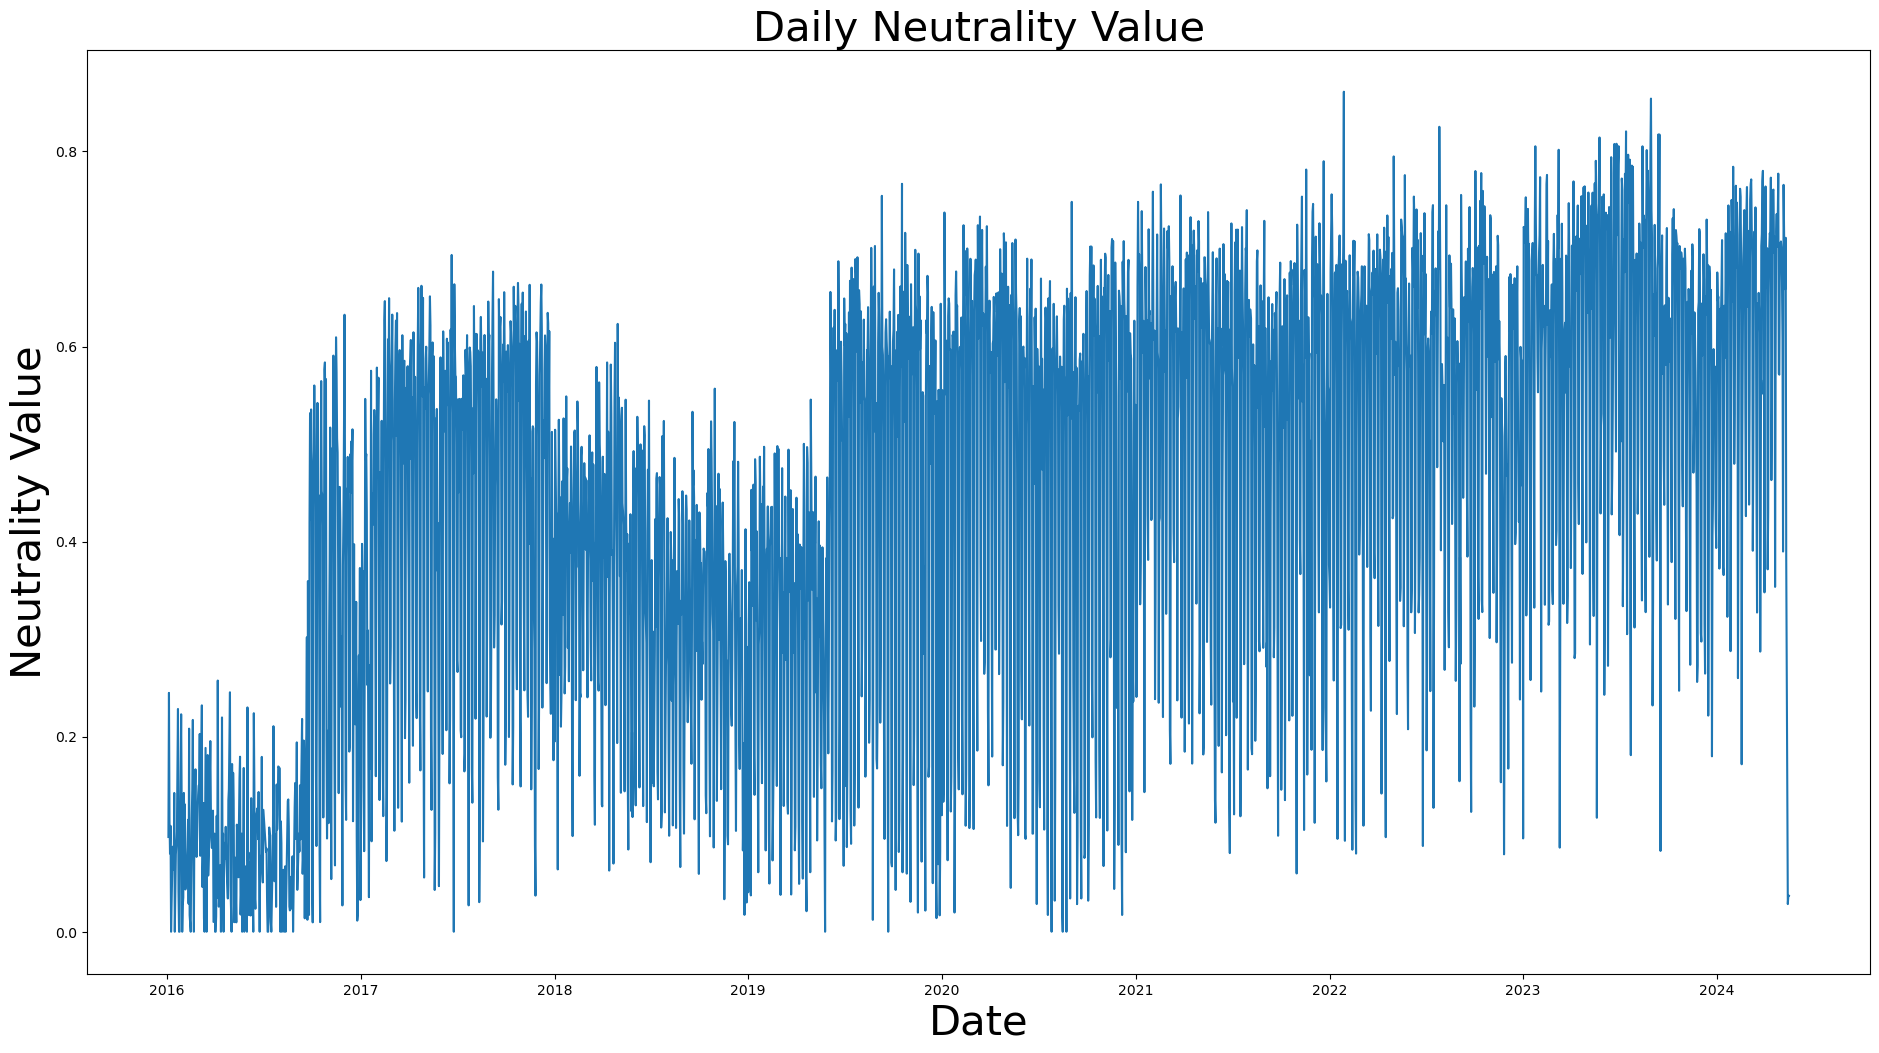

In [29]:
# Plot of the neutrality

plt.figure(figsize=(23, 12))
plt.title('Daily Neutrality Value', fontsize = 30)
plt.xlabel('Date', fontsize = 30)
plt.ylabel('Neutrality Value', fontsize = 30)

plt.plot(final_modified['date'] ,final_modified['neutrality_weighted']) 

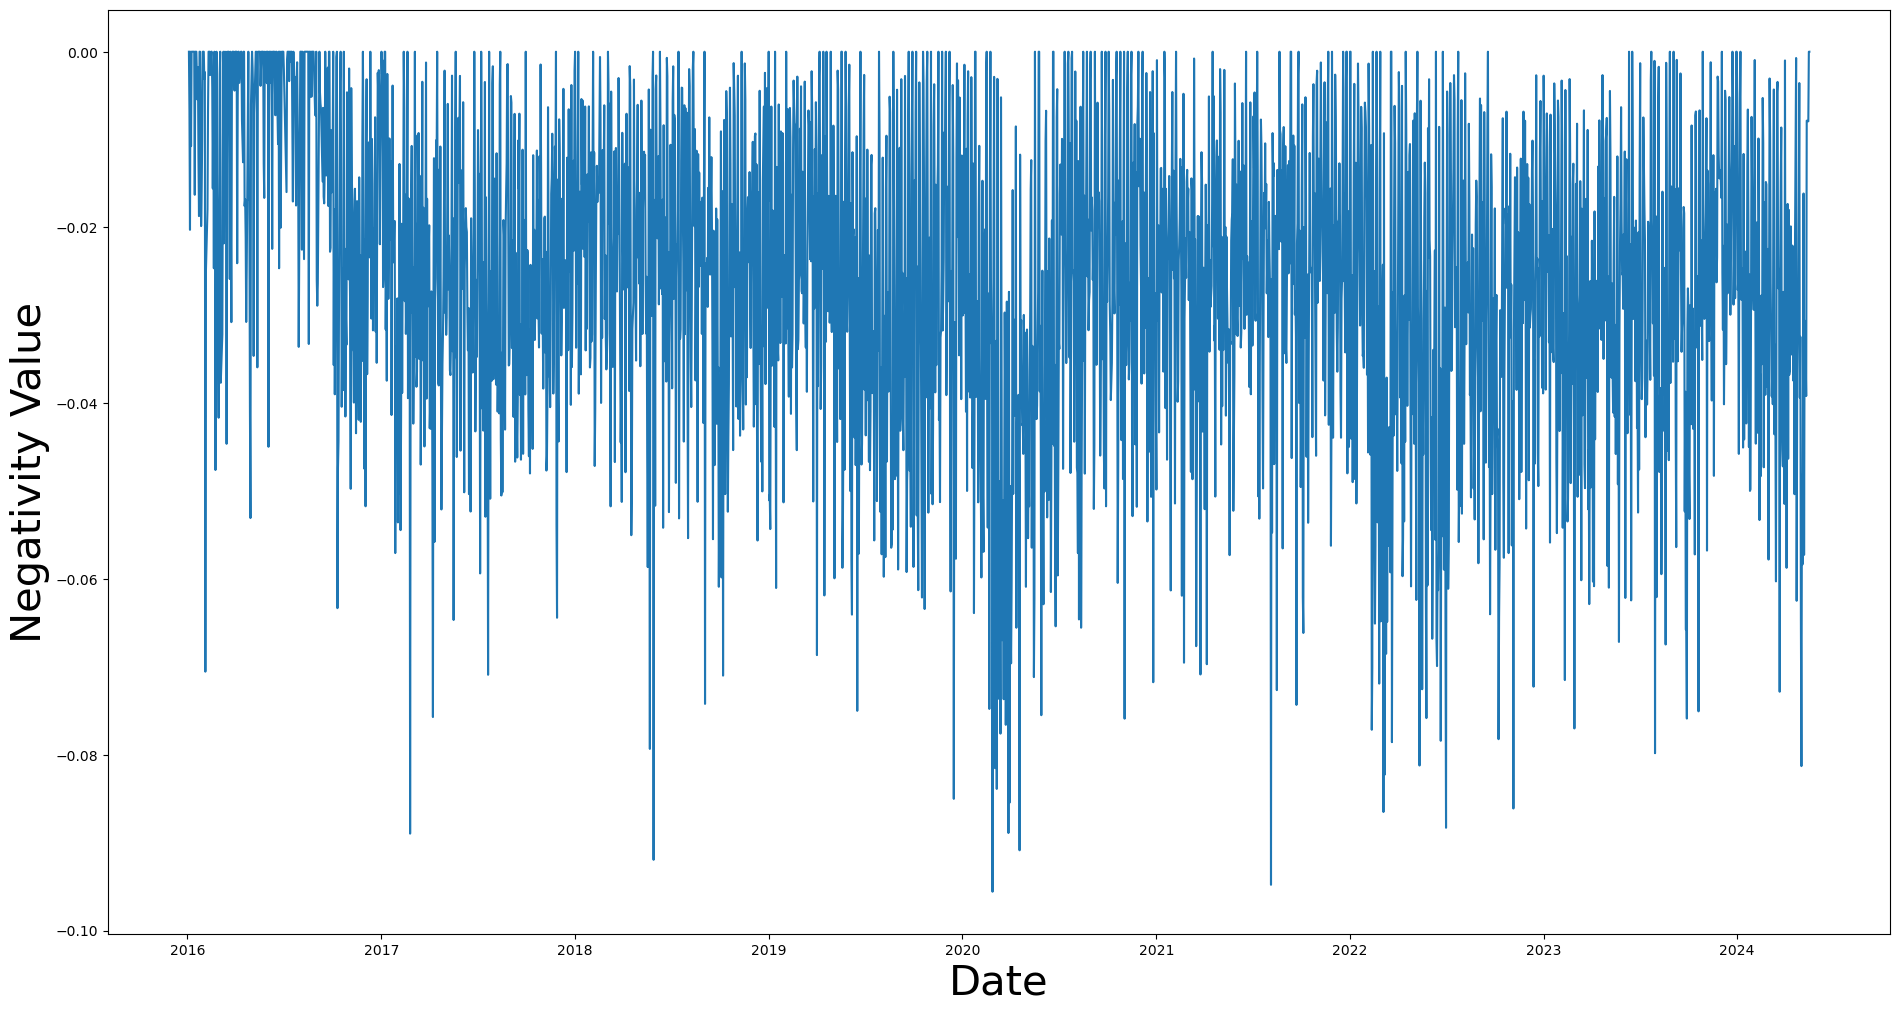

In [30]:
# Plot of the negativity

plt.figure(figsize=(23, 12))
# plt.title('Daily Negativity Value', fontsize = 30)
plt.xlabel('Date', fontsize = 30)
plt.ylabel('Negativity Value', fontsize = 30)

plt.plot(final_modified['date'] ,-final_modified['negativity_weighted']) 

# Plot of the Yearly Sentiment Data

In [31]:
# add year columns
final['year'] = final['date'].dt.year
final

,date,positivity_weighted,neutrality_weighted,negativity_weighted,compound_weighted,year
0,2005-01-06,0.000000,0.000000,0.000000,0.000000,2005
1,2005-01-13,0.000000,0.000000,0.000000,0.000000,2005
2,2005-01-18,0.000000,0.009989,0.000000,0.000000,2005
3,2005-01-19,0.000000,0.016590,0.000000,0.000000,2005
4,2005-01-20,0.000000,0.000000,0.000000,0.000000,2005
...,...,...,...,...,...,...
4796,2024-05-10,0.091895,0.711477,0.039176,0.094914,2024
4797,2024-05-11,0.124024,0.383307,0.007845,0.193947,2024
4798,2024-05-14,0.003137,0.028346,0.007920,-0.007291,2024
4799,2024-05-15,0.002010,0.037394,0.000000,0.002657,2024


In [32]:
# compute yearly mean for each score
final_yearly = final.groupby(['year']).agg({
    'positivity_weighted': 'mean',
    'neutrality_weighted': 'mean',
    'negativity_weighted': 'mean',
    'compound_weighted': 'mean'
}).reset_index()

# check
final_yearly.head(-5)

,year,positivity_weighted,neutrality_weighted,negativity_weighted,compound_weighted
0,2005,0.000614,0.006708,0.000223,0.000743
1,2006,0.000863,0.005709,0.000212,0.001167
2,2007,0.000776,0.005567,0.000074,0.001283
3,2008,0.001181,0.006317,0.000164,0.001694
4,2011,0.006310,0.059075,0.005622,0.000309
5,2012,0.006181,0.054545,0.005532,0.000807
6,2013,0.012997,0.108582,0.009003,0.004638
7,2014,0.012659,0.092906,0.009543,0.003166
8,2015,0.011387,0.083974,0.007935,0.005132
9,2016,0.019351,0.166533,0.012211,0.010830


In [33]:
# print LaTeX
print(final_yearly.drop(columns=['year']).describe().to_latex(
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,))

\begin{tabular}{lrrrr}
\toprule
 & positivity_weighted & neutrality_weighted & negativity_weighted & compound_weighted \\
\midrule
count & 18.000 & 18.000 & 18.000 & 18.000 \\
mean & 0.033 & 0.251 & 0.015 & 0.030 \\
std & 0.033 & 0.233 & 0.012 & 0.038 \\
min & 0.001 & 0.006 & 0.000 & 0.000 \\
25% & 0.006 & 0.056 & 0.006 & 0.001 \\
50% & 0.016 & 0.138 & 0.011 & 0.008 \\
75% & 0.062 & 0.470 & 0.027 & 0.050 \\
max & 0.100 & 0.606 & 0.032 & 0.120 \\
\bottomrule
\end{tabular}



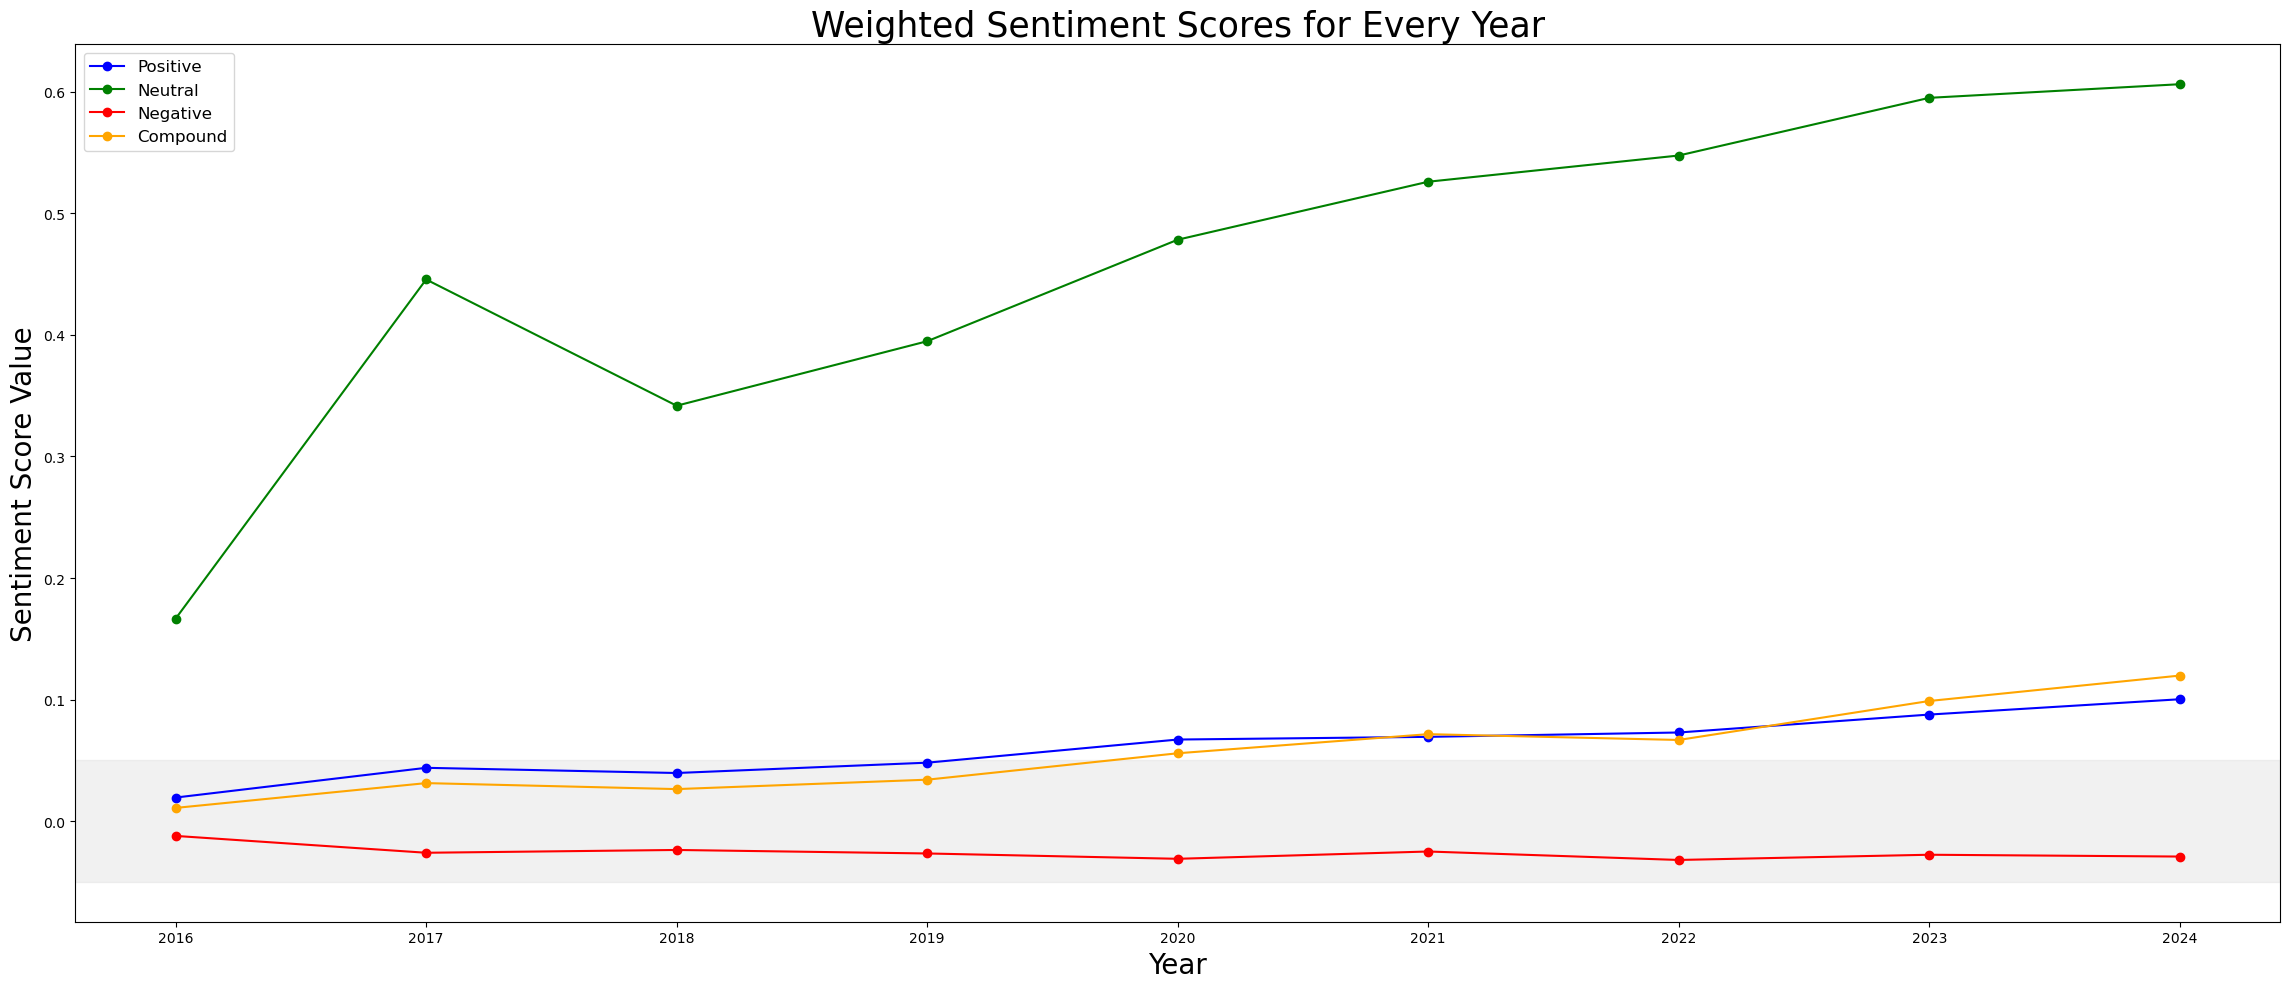

In [34]:
# Filter data starting from 2016
final_yearly = final_yearly[final_yearly['year'] >= 2016]

# Create a figure and axes for a single subplot
fig, ax = plt.subplots(figsize=(23, 10))

# Plot mean positivity
ax.plot(final_yearly['year'], final_yearly['positivity_weighted'], marker='o', linestyle='-', color='blue', label='Positive')

# Plot mean neutrality
ax.plot(final_yearly['year'], final_yearly['neutrality_weighted'], marker='o', linestyle='-', color='green', label='Neutral')

# Plot mean negativity (display as negative values)
ax.plot(final_yearly['year'], -final_yearly['negativity_weighted'], marker='o', linestyle='-', color='red', label='Negative')

# Plot mean compound
ax.plot(final_yearly['year'], final_yearly['compound_weighted'], marker='o', linestyle='-', color='orange', label='Compound')

# Add a light grey shaded area from -0.05 to +0.05 on the y-axis
ax.axhspan(-0.05, 0.05, color='lightgrey', alpha=0.3)

# Set title and labels for the subplot
ax.set_title('Weighted Sentiment Scores for Every Year', fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Sentiment Score Value', fontsize=20)

# Place legend inside the plot and make it bigger
ax.legend(loc='upper left', fontsize='large')

# Set x-axis ticks and rotate them
ax.set_xticks(final_yearly['year'].unique())
ax.tick_params(axis='x', rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Plot of the monthly data for each year

In [37]:
final['month'] = final['date'].dt.month
final

,date,positivity_weighted,neutrality_weighted,negativity_weighted,compound_weighted,year,month
0,2005-01-06,0.000000,0.000000,0.000000,0.000000,2005,1
1,2005-01-13,0.000000,0.000000,0.000000,0.000000,2005,1
2,2005-01-18,0.000000,0.009989,0.000000,0.000000,2005,1
3,2005-01-19,0.000000,0.016590,0.000000,0.000000,2005,1
4,2005-01-20,0.000000,0.000000,0.000000,0.000000,2005,1
...,...,...,...,...,...,...,...
4796,2024-05-10,0.091895,0.711477,0.039176,0.094914,2024,5
4797,2024-05-11,0.124024,0.383307,0.007845,0.193947,2024,5
4798,2024-05-14,0.003137,0.028346,0.007920,-0.007291,2024,5
4799,2024-05-15,0.002010,0.037394,0.000000,0.002657,2024,5


In [38]:
# compute monthly mean for each score
final_monthly = final.groupby(['year', 'month']).agg({
    'positivity_weighted': 'mean',
    'neutrality_weighted': 'mean',
    'negativity_weighted': 'mean',
    'compound_weighted': 'mean'
}).reset_index()

# check
final_monthly.head(-5)

,year,month,positivity_weighted,neutrality_weighted,negativity_weighted,compound_weighted
0,2005,1,0.000000,0.003322,0.000000,0.000000
1,2005,2,0.000320,0.004385,0.000389,-0.000231
2,2005,3,0.000355,0.006456,0.000000,0.000761
3,2005,4,0.000131,0.005590,0.000285,-0.000257
4,2005,5,0.001241,0.009495,0.000000,0.002804
...,...,...,...,...,...,...
189,2023,8,0.091983,0.641381,0.031587,0.103386
190,2023,9,0.079041,0.583809,0.030342,0.081581
191,2023,10,0.098084,0.594136,0.030191,0.112368
192,2023,11,0.098121,0.561546,0.020792,0.127261


In [40]:
final_monthly_filtered = final_monthly[final_monthly['year'] >= 2016]
final_monthly_filtered

,year,month,positivity_weighted,neutrality_weighted,negativity_weighted,compound_weighted
98,2016,1,0.014016,0.095669,0.005930,0.011689
99,2016,2,0.017818,0.099198,0.013302,0.003489
100,2016,3,0.011340,0.103399,0.010406,0.001191
101,2016,4,0.014792,0.089650,0.011804,0.003320
102,2016,5,0.010926,0.071076,0.004889,0.009788
...,...,...,...,...,...,...
194,2024,1,0.100112,0.588566,0.026222,0.125998
195,2024,2,0.104331,0.625414,0.028252,0.134191
196,2024,3,0.104569,0.605125,0.028969,0.123230
197,2024,4,0.103359,0.654327,0.031991,0.117656


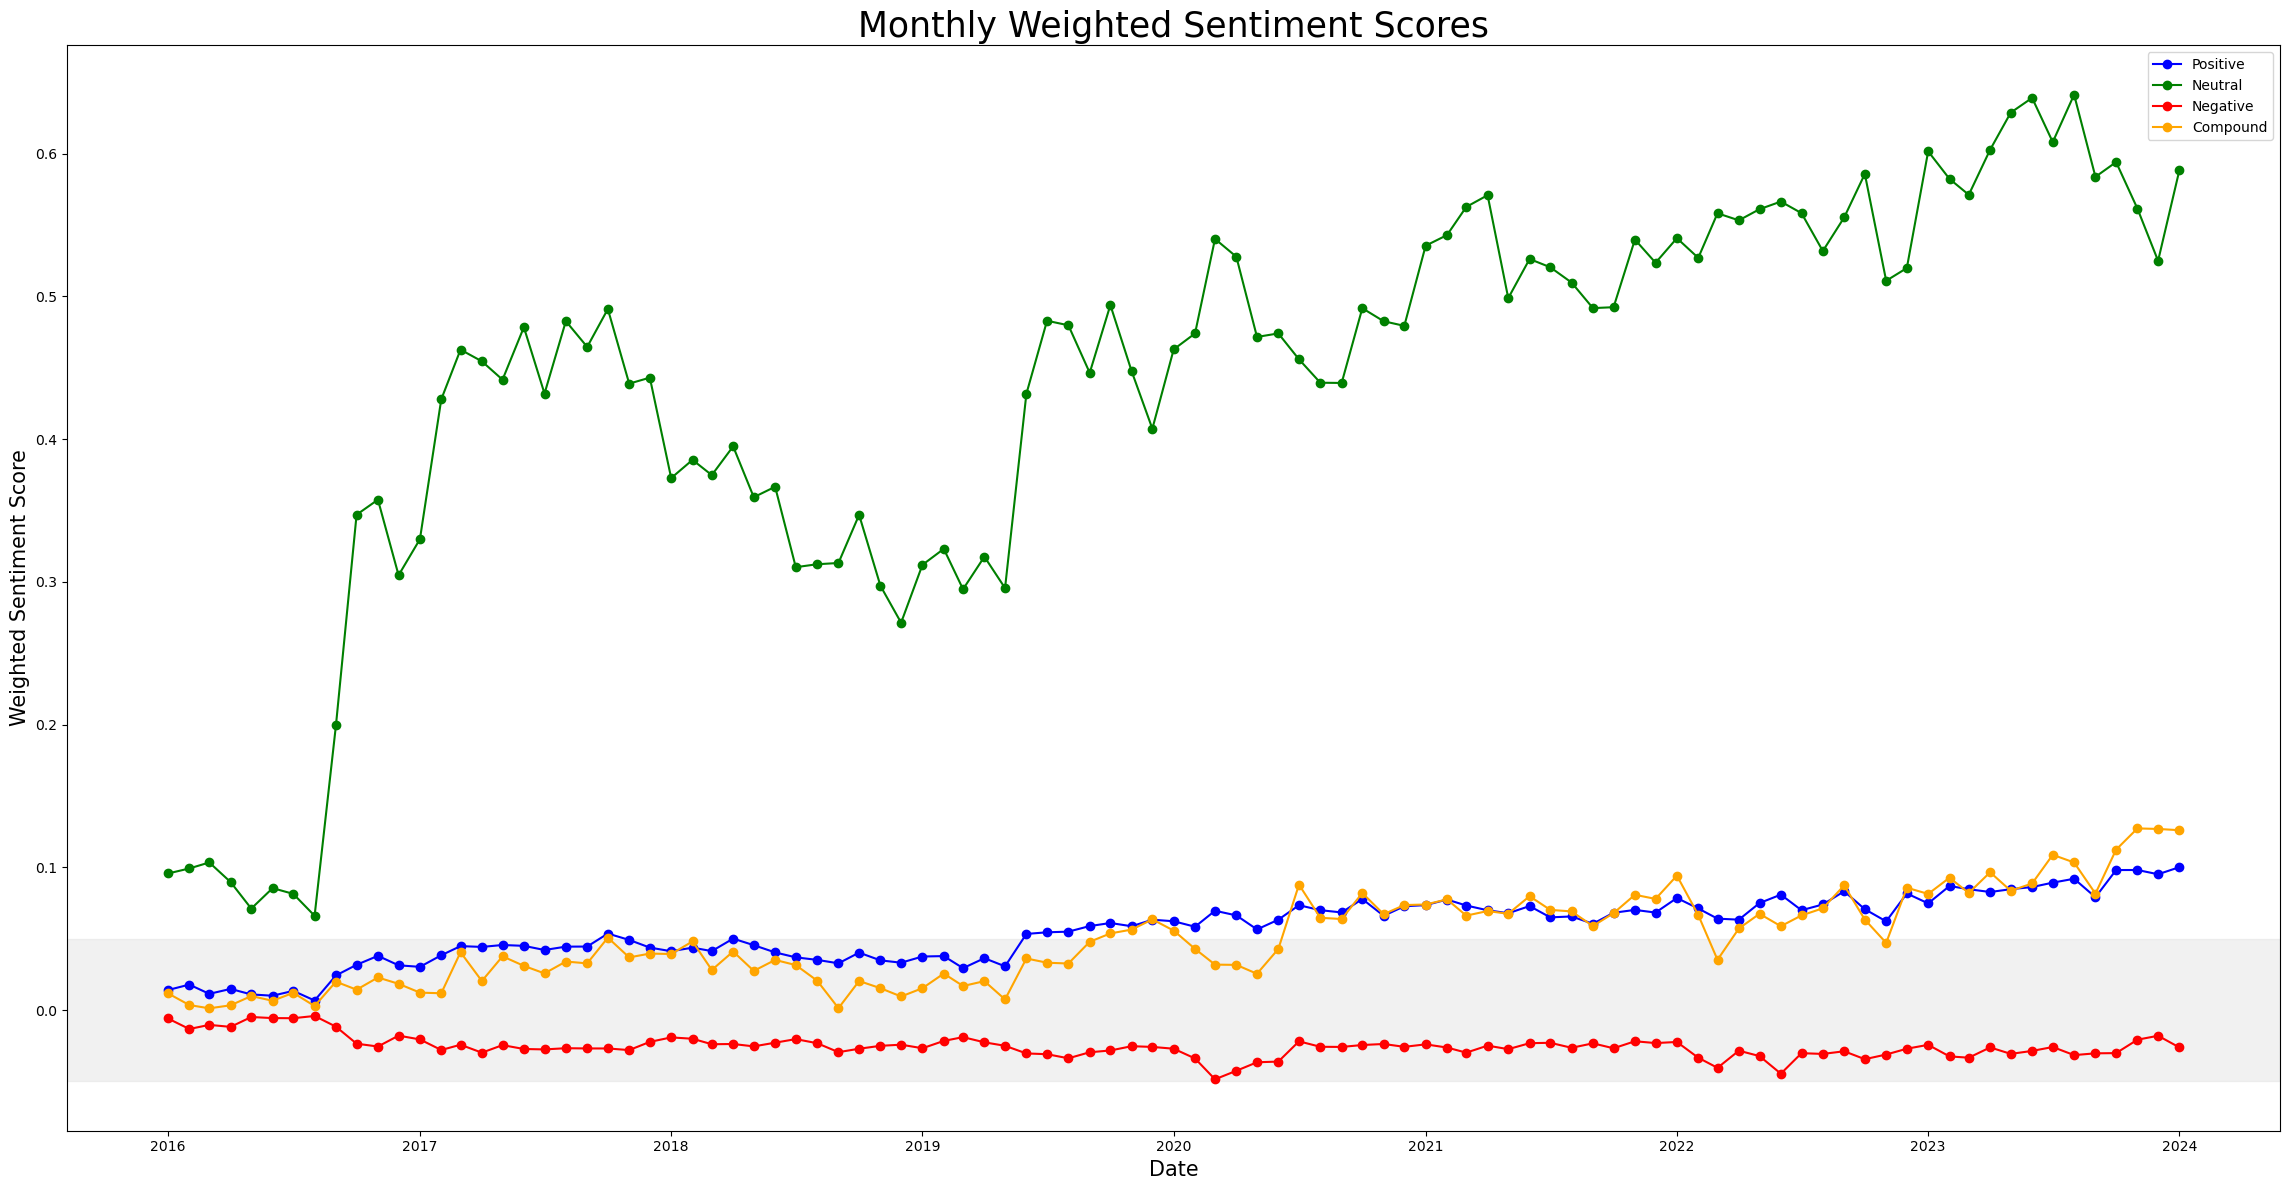

In [42]:
# Create a complete date range from January 2016 to January 2024
date_range = pd.date_range(start='2016-01-01', end='2024-01-01', freq='MS')

# Convert the 'year' and 'month' columns to integers before creating the 'date' column
final_monthly_filtered['year'] = final_monthly_filtered['year'].astype(int)
final_monthly_filtered['month'] = final_monthly_filtered['month'].astype(int)

# Convert the 'year' and 'month' columns to datetime format
final_monthly_filtered['date'] = pd.to_datetime(final_monthly_filtered['year'].astype(str) + '-' + final_monthly_filtered['month'].astype(str).str.zfill(2) + '-01')

# Merge with the complete date range to fill missing months
final_monthly_filtered = pd.merge(final_monthly_filtered, pd.DataFrame(date_range, columns=['date']), how='right', on='date')

# Sort by date
final_monthly_filtered = final_monthly_filtered.sort_values('date')

# Interpolate missing values
final_monthly_filtered['positivity_weighted'].interpolate(inplace=True)
final_monthly_filtered['neutrality_weighted'].interpolate(inplace=True)
final_monthly_filtered['negativity_weighted'].interpolate(inplace=True)
final_monthly_filtered['compound_weighted'].interpolate(inplace=True)

# Create a new figure
plt.figure(figsize=(23, 12))

# Plot mean positivity
plt.plot(final_monthly_filtered['date'], final_monthly_filtered['positivity_weighted'], marker='o', linestyle='-', color='blue', label='Positive')

# Plot mean neutrality
plt.plot(final_monthly_filtered['date'], final_monthly_filtered['neutrality_weighted'], marker='o', linestyle='-', color='green', label='Neutral')

# Plot mean negativity (display as negative values)
plt.plot(final_monthly_filtered['date'], -final_monthly_filtered['negativity_weighted'], marker='o', linestyle='-', color='red', label='Negative')

# Plot mean compound
plt.plot(final_monthly_filtered['date'], final_monthly_filtered['compound_weighted'], marker='o', linestyle='-', color='orange', label='Compound')

# Add a light grey shaded area from -0.05 to +0.05 on the y-axis
plt.axhspan(-0.05, 0.05, color='lightgrey', alpha=0.3)

# Set title and labels for the plot
plt.title('Monthly Weighted Sentiment Scores', fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Weighted Sentiment Score', fontsize=15)
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# print CSV file which will be used in the ML model
final.to_csv('final_data_weights.csv')

In [46]:
# summary statistics of daily weighted scores

print(final.drop(columns=['year', 'month', 'date']).describe().to_latex(
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,))

\begin{tabular}{lrrrr}
\toprule
 & positivity_weighted & neutrality_weighted & negativity_weighted & compound_weighted \\
\midrule
count & 4801.000 & 4801.000 & 4801.000 & 4801.000 \\
mean & 0.040 & 0.306 & 0.019 & 0.034 \\
std & 0.040 & 0.256 & 0.018 & 0.056 \\
min & 0.000 & 0.000 & 0.000 & -0.154 \\
25% & 0.003 & 0.067 & 0.000 & 0.000 \\
50% & 0.028 & 0.237 & 0.016 & 0.014 \\
75% & 0.068 & 0.570 & 0.031 & 0.065 \\
max & 0.222 & 0.861 & 0.096 & 0.328 \\
\bottomrule
\end{tabular}

